In [24]:
%load_ext autoreload
%autoreload 2

import numpy as np
import os
from deep_bf.data_handler import DataLoader
import torch
import numpy as np
from tqdm import tqdm
import h5py
import hdf5plugin
import webdataset as wds

data_path = "/home/panda/rf_data/dataset/raw"
img_path = "/home/panda/rf_data/dataset/img"
webdataset_path = "/home/panda/rf_data/dataset/webdataset"
samples_idx_path = "/home/panda/rf_data/dataset/samples_idx"

dl = DataLoader("/home/panda/rf_data/")

nz = 2048
nx = 256
new_Ns = 2800

device = "cuda"
dtype = torch.float32

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [29]:
from deep_bf.models import GlobalSamplesIdx

df = dl.get_df()
gsi = GlobalSamplesIdx(df, samples_idx_path)

In [ ]:
dataset = wds.WebDataset(f"{webdataset_path}/dataset-000.tar", shardshuffle=False).decode()
it = iter(dataset)

i = 34
for _ in range(i):
    sample = next(it)

In [41]:
name = sample["__key__"]
rf = sample["rf.npy"]
#gt = sample["gt.npy"]
#idx_id = sample["samples_idx_id.txt"]
meta = sample["meta.json"]
idx_id = meta["samples_idx_id"]
print(meta["idx"])

#with h5py.File(f"{samples_idx_path}/{idx_id}.hdf5", "r") as f:
    #samples_idx = f["samples_idx"][:]

samples_idx = gsi.get_samples_idx(idx_id)

print(name)

33
OSL003


In [42]:
import torch.nn.functional as F

norm_factor = 2.0 / (2800 - 1)

rf = torch.from_numpy(rf).to(device=device, dtype=dtype)
samples_idx = torch.from_numpy(samples_idx).to(device=device, dtype=dtype)

rf = rf.reshape(128, 1, 1, 2800)
grid = torch.zeros(128, nz, nx, 2, device=device, dtype=dtype)
grid[..., 0] = samples_idx * norm_factor - 1.0

selected_samples =  F.grid_sample(
    rf,
    grid,
    mode="bilinear",
    padding_mode="zeros",
    align_corners=True,
)

selected_samples = selected_samples.view(128, nz, nx)
bf = selected_samples.sum(dim=0).cpu()

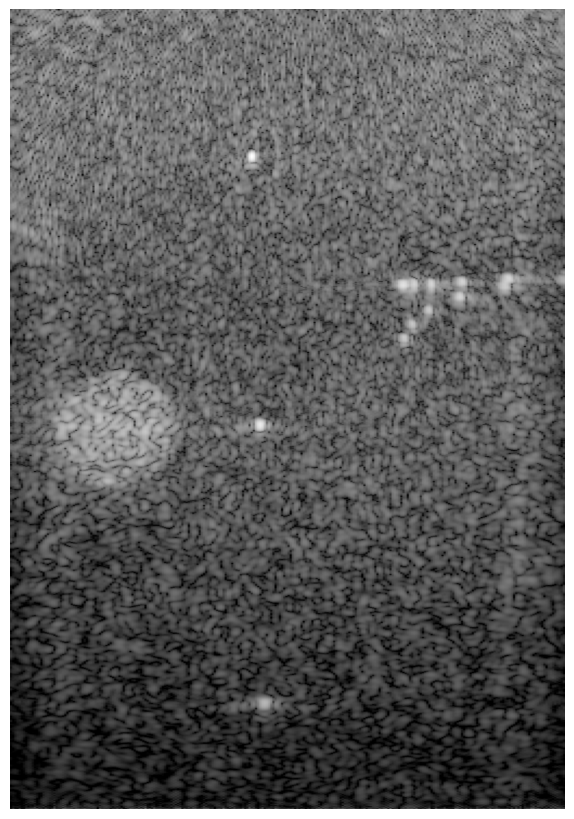

In [43]:
import matplotlib.pyplot as plt
from deep_bf.beamformers import compute_meshgrid, get_rf_bmode

pw = dl.get_defined_pwdata(name, "RF")
Z, X = compute_meshgrid(pw, nz, nx)

Z = Z.cpu()
X = X.cpu()

zlims = np.array([Z[0, 0], Z[-1, 0]]) * 1e3
xlims = np.array([X[0, 0], X[0, -1]]) * 1e3

vmin = -60
vmax = 0

fig = plt.figure(figsize=(6, 8), frameon=False)
ax = fig.add_axes([0, 0, 1, 1])

b_mode = get_rf_bmode(bf, vmin, vmax)
extent = (xlims[0], xlims[-1], zlims[-1], zlims[0])

ax.imshow(b_mode, cmap='gray', vmin=vmin, vmax=vmax,
          extent=extent,
          aspect='equal')
ax.set_axis_off()
plt.show()